# Final Project

### DS 6014

### Jiaxing Qiu, Mark Tenzer, Shenghua Wu

# Data processing

In [1]:
# Imports
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

In [2]:
# Read raw data

# These datasets are hundreds of megabytes in size.
# To save memory, only read the columns we'll actually use. We can change these later.
# This allows us to drop many memory-expensive columns, such as the recipe description or review text.

recipes = pd.read_csv('RAW_recipes.csv', usecols=['id',           
                                                  'nutrition',                            
                                                  'minutes', 'n_steps', 'n_ingredients']) 
interactions = pd.read_csv('RAW_interactions.csv', usecols=['recipe_id', 'rating'])

In [3]:
# Merge the data on recipe ids
data = recipes.merge(interactions, left_on='id', right_on='recipe_id')

# Drop the id columns and other unnecessary columns
data.drop(columns=['id', 'recipe_id'], inplace=True)

# Drop non-reviews (ratings encoded as 0 are comments)
data = data[data['rating'] != 0]

# As above (for tags and ingredients), reformat nutrition to be a list
# Remove [ and ] characters (at start and end)
data['nutrition'] = data['nutrition'].str[1:-1]
# Remove ' characters
data['nutrition'] = data['nutrition'].str.replace("'", "")
# Split into list
data['nutrition'] = data['nutrition'].str.split(", ")

# Put each nutrition fact into a properly-named column
for i, nutrition_fact in enumerate(["calories", "total_fat", "sugar", "sodium", "protein", "saturated_fat", "carbohydrates"]):
    data[nutrition_fact] = data['nutrition'].apply(lambda x: x[i]).astype('float64')

# Drop the now-unnecessary column
data.drop(columns=['nutrition'], inplace=True)

# Drop problematic values of minutes
data = data[ data['minutes'] > 0]
data = data[ data['minutes'] <= 60 * 6]

#data.to_csv("newdata.csv", index=False)
data.head()

,minutes,n_steps,n_ingredients,rating,calories,total_fat,sugar,sodium,protein,saturated_fat,carbohydrates
0,55,11,7,5,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,55,11,7,5,51.5,0.0,13.0,0.0,2.0,0.0,4.0
2,55,11,7,5,51.5,0.0,13.0,0.0,2.0,0.0,4.0
4,30,9,6,5,173.4,18.0,0.0,17.0,22.0,35.0,1.0
5,30,9,6,4,173.4,18.0,0.0,17.0,22.0,35.0,1.0


## Problem 1

In [4]:
# Get the X and Y variables
X = np.array(data.drop(columns=['rating']))
Y = np.array(data['rating'] == 5)
# Scale the X data
X = StandardScaler().fit_transform(X)

# Subset the data
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=100000)

# Number of predictors
k = X.shape[1]

## Simple logistic regression

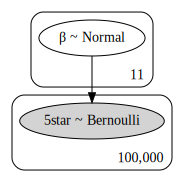

In [5]:
with pm.Model() as problem1_simple:
    
    # Beta coefficients for predictor variables and intercept
    β = pm.Normal('β', mu=0, sd=1, shape=k+1)
    
    # Calculate logit from the normal variables, and add itercept
    logit = pm.math.dot(β[1:], Xtrain.T) + β[0]

    # Pass the logits to a Bernoulli outcome, with the observed data
    y_pred = pm.Bernoulli('5star', logit_p=logit, observed=Ytrain)

pm.model_to_graphviz(problem1_simple)

## Logistic regression with hierarchical priors

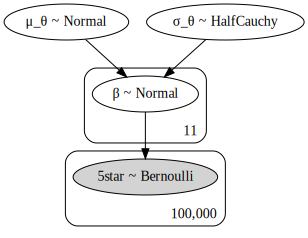

In [6]:
with pm.Model() as problem1_priors:
    
    # Priors
    mu_theta = pm.Normal('μ_θ', 0, 1)
    sd_theta = pm.HalfCauchy('σ_θ', 5)
    
    # Beta coefficients for predictor variables and intercept
    β = pm.Normal('β', mu=mu_theta, sd=sd_theta, shape=k+1)
    
    # Calculate logit from the normal variables, and add itercept
    logit = pm.math.dot(β[1:], Xtrain.T) + β[0]

    # Pass the logits to a Bernoulli outcome, with the observed data
    y_pred = pm.Bernoulli('5star', logit_p=logit, observed=Ytrain)
    
pm.model_to_graphviz(problem1_priors)

## Run all models

In [7]:
with problem1_simple:
    # Variational inference with ADVI optimization
    advi_fit_simple = pm.fit(50000, method='advi')
    
with problem1_priors:
    # Variational inference with ADVI optimization
    advi_fit_priors = pm.fit(50000, method='advi')

Average Loss = 54,576: 100%|██████████| 50000/50000 [04:10<00:00, 199.24it/s]
Finished [100%]: Average Loss = 54,576
Average Loss = 54,575: 100%|██████████| 50000/50000 [04:00<00:00, 207.95it/s]
Finished [100%]: Average Loss = 54,575


In [8]:
# sample from the variational posterior distribution
PPC_SAMPLES = 5000
advi_trace_simple = advi_fit_simple.sample(PPC_SAMPLES)
advi_trace_priors = advi_fit_priors.sample(PPC_SAMPLES)

## Compare the results

In [9]:
# WAIC comparisons
cmp_df = az.compare({'simple':advi_trace_simple, 'beta_priors':advi_trace_priors},
                    method='BB-pseudo-BMA')
cmp_df

/Users/wushenghua/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
simple,0,109075,15.9693,0,0.524066,313.389,0,True,deviance
beta_priors,1,109075,15.287,0.342098,0.475934,313.801,2.82013,True,deviance


## Estimates and uncertainty

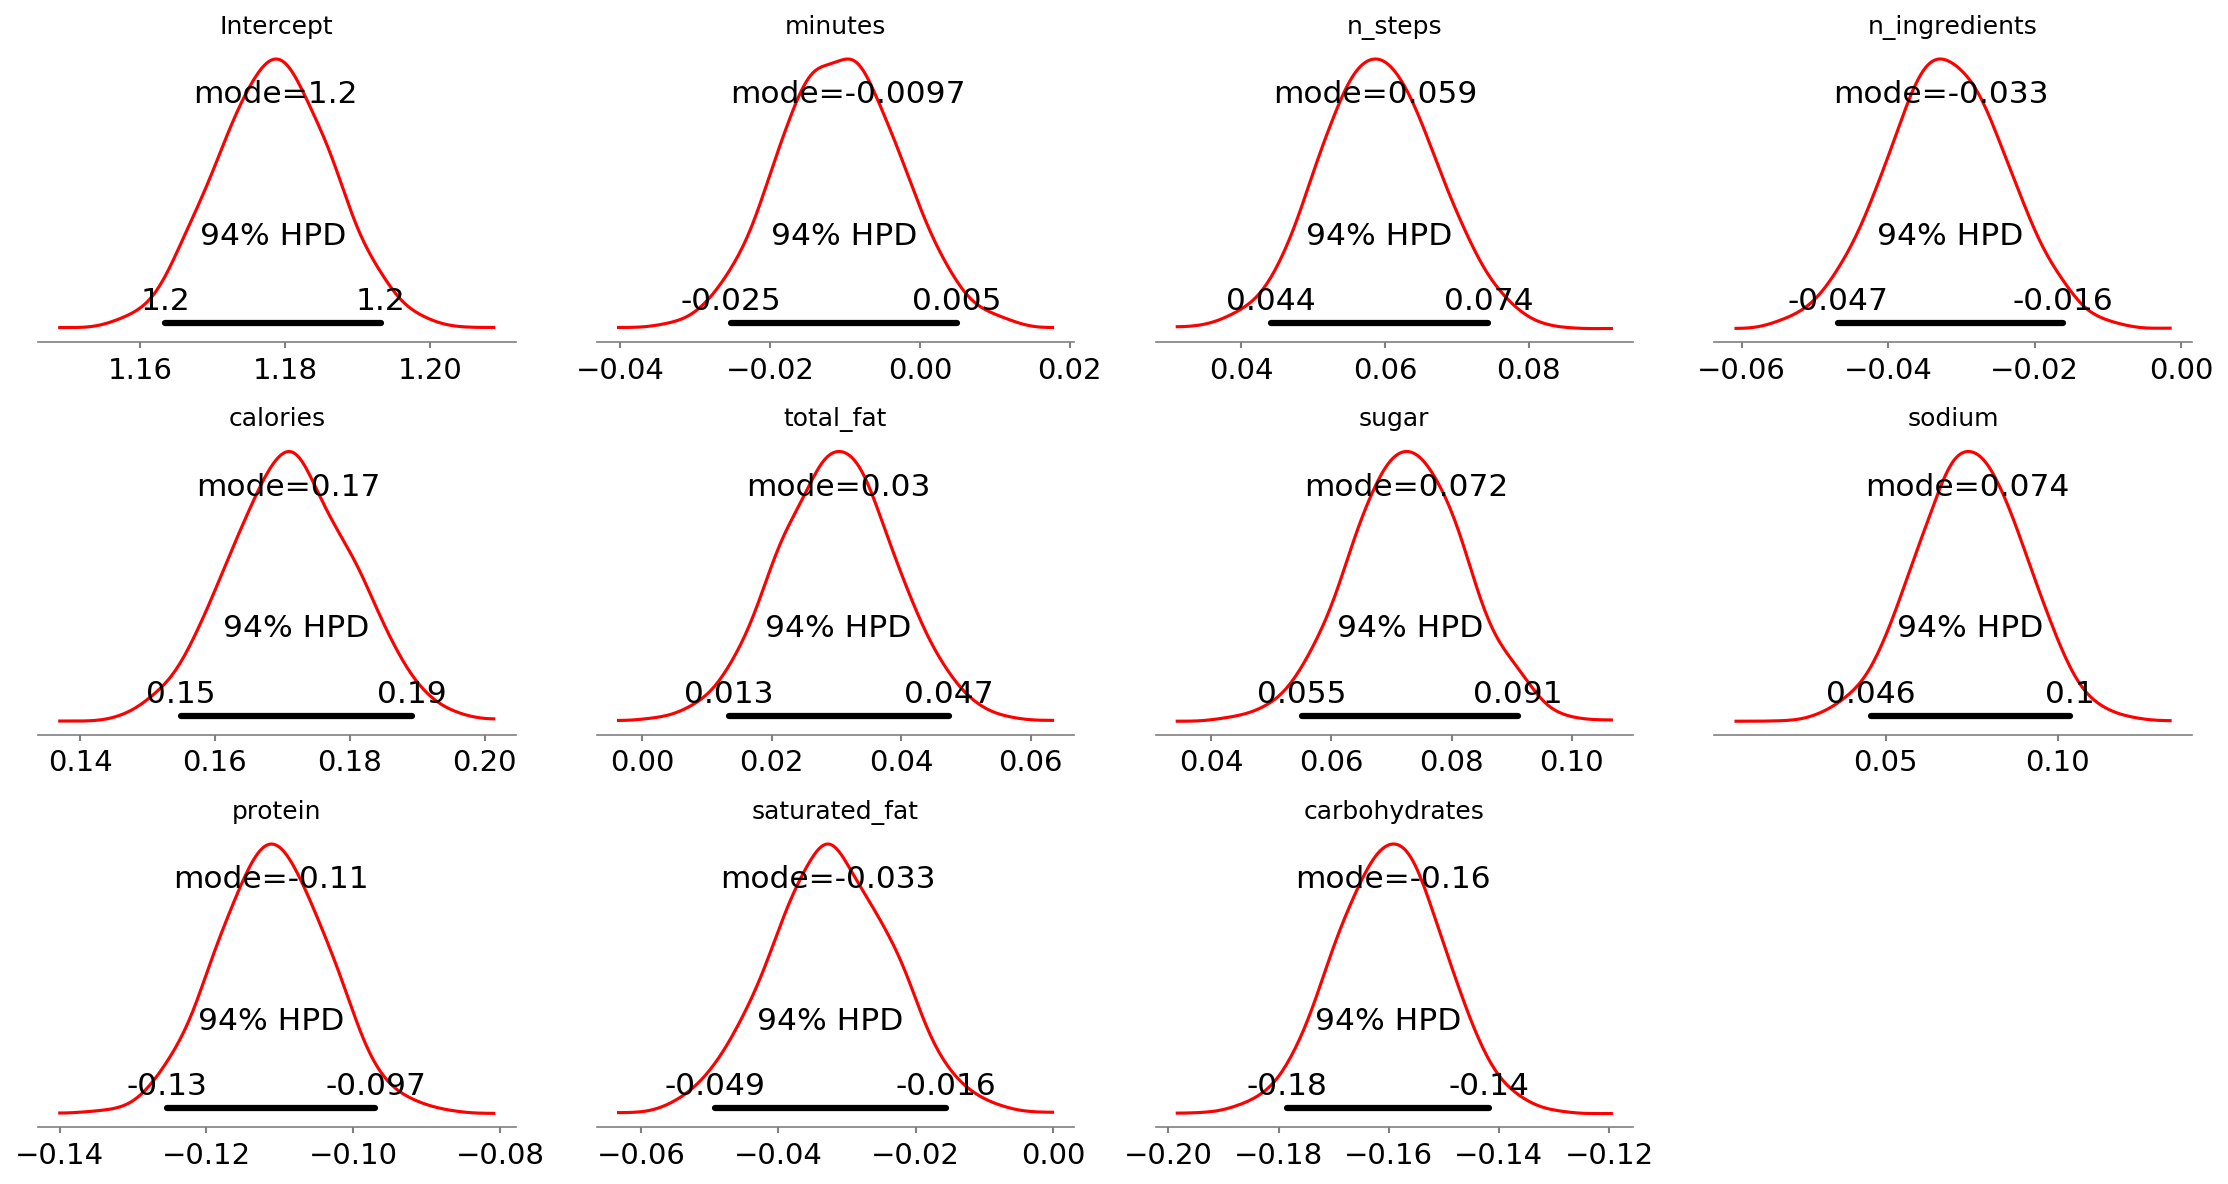

<Figure size 432x288 with 0 Axes>

In [10]:
advi_betas = advi_trace_simple['β']

# Plot posteriors

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 8), dpi=150)
axes = axes.ravel()

for col, estimate_advi, title, xlabel in zip(range(k+1),
                               [advi_betas[:,i] for i in range(k+1)],
                               ['Intercept'] + list(data.drop(columns=['rating']).columns),
                               ['Intercept'] + list(data.drop(columns=['rating']).columns)):
    
    pm.plot_posterior(estimate_advi, point_estimate='mode', ax=axes[col], color='red')
    
    axes[col].set_title(title, fontsize=12)

    #axes[col].set_xlabel(xlabel, fontsize=12)
    
for ax in axes[(k+1):]:
    ax.axis('off')

plt.tight_layout()
plt.show()
plt.savefig('problem1.png')

# Problem 2

In [11]:
data2 = pd.DataFrame(recipes['nutrition'])

# As above (for tags and ingredients), reformat nutrition to be a list
# Remove [ and ] characters (at start and end)
data2['nutrition'] = data2['nutrition'].str[1:-1]
# Remove ' characters
data2['nutrition'] = data2['nutrition'].str.replace("'", "")
# Split into list
data2['nutrition'] = data2['nutrition'].str.split(", ")

# Put each nutrition fact into a properly-named column
for i, nutrition_fact in enumerate(["calories", "total_fat", "sugar", "sodium", "protein", "saturated_fat", "carbohydrates"]):
    data2[nutrition_fact] = data2['nutrition'].apply(lambda x: x[i]).astype('float64')

# Drop the now-unnecessary column
data2.drop(columns=['nutrition'], inplace=True)

# Drop unneeded columns
#data3.drop(columns=['total_fat','calories','protein','carbohydrates', 'sugar','sodium','saturated_fat'], inplace=True)

data2.head()

,calories,total_fat,sugar,sodium,protein,saturated_fat,carbohydrates
0,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,269.8,22.0,32.0,48.0,39.0,27.0,5.0
3,368.1,17.0,10.0,2.0,14.0,8.0,20.0
4,352.9,1.0,337.0,23.0,3.0,0.0,28.0


In [12]:
# Get the X and Y variables
X = np.array(data2.drop(columns=['calories']))
Y = np.array(data2['calories'])
# Scale the data

scaler = StandardScaler()
X = scaler.fit_transform(X)

Ymean, Ystd = Y.mean(), Y.std()
Y = (Y - Ymean) / Ystd

means = [Ymean] + list(scaler.mean_)
stds = [Ystd] + list(scaler.var_ ** .5)

# Subset the data
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=100000)

# Number of predictors
k = X.shape[1]

## Simple linear regression

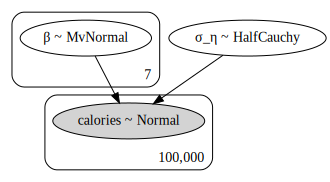

In [13]:
with pm.Model() as problem2_simple:
    
    # Beta coefficients for predictor variables and intercept
    β = pm.MvNormal('β', mu=np.zeros(k+1), cov=1e5 * np.eye(k+1), shape=k+1)
    # Error term
    sigma_eta = pm.HalfCauchy('σ_η', 5)

    # The result is a Normal, with mean based on the Betas and X-data, and variance sigma_eta.
    y_pred = pm.Normal('calories', mu = pm.math.dot(β[1:], Xtrain.T) + β[0], sd = sigma_eta, observed=Ytrain)

pm.model_to_graphviz(problem2_simple)

## Linear regression, with a subjective prior

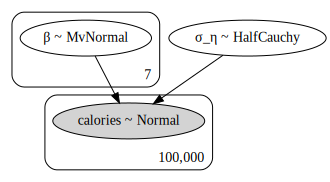

In [14]:
with pm.Model() as problem2_subj:
    
    # Beta coefficients for predictor variables and intercept
    β = pm.MvNormal('β', mu=np.array((0, 9, 0, 0, 4, 0, 4)) / stds, cov=1e5 * np.eye(k+1), shape=k+1)
    # Error term
    sigma_eta = pm.HalfCauchy('σ_η', 5)

    # The result is a Normal, with mean based on the Betas and X-data, and variance sigma_eta.
    y_pred = pm.Normal('calories', mu = pm.math.dot(β[1:], Xtrain.T) + β[0], sd = sigma_eta, observed=Ytrain)
    
pm.model_to_graphviz(problem2_subj)

## Linear regression, with hierarchical priors

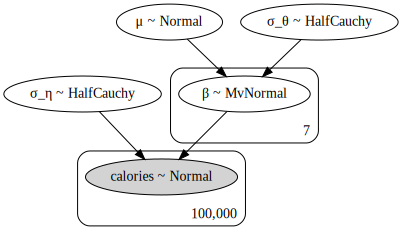

In [15]:
with pm.Model() as problem2_hier:
    
    # Uninformative priors
    mu = pm.Normal('μ', mu=0, sd=1e5)
    sigma_theta = pm.HalfCauchy('σ_θ', 5)
    
    # Beta coefficients for predictor variables and intercept
    β = pm.MvNormal('β', mu=mu, cov=sigma_theta * np.eye(k+1), shape=k+1)
    # Error term
    sigma_eta = pm.HalfCauchy('σ_η', 5)

    # The result is a Normal, with mean based on the Betas and X-data, and variance sigma_eta.
    y_pred = pm.Normal('calories', mu = pm.math.dot(β[1:], Xtrain.T) + β[0], sd = sigma_eta, observed=Ytrain)
    
pm.model_to_graphviz(problem2_hier)

## Linear regression, with hierarchical *and* subjective priors

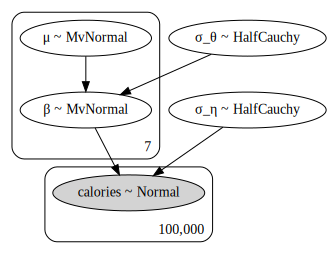

In [16]:
with pm.Model() as problem2_subj_hier_7:
    
    # Informative priors
    mu = pm.MvNormal('μ', mu=np.array((0, 9, 0, 0, 4, 0, 4)) / stds, cov=1e5 * np.eye(k+1), shape=k+1)
    sigma_theta = pm.HalfCauchy('σ_θ', 5)
    
    # Beta coefficients for predictor variables and intercept
    β = pm.MvNormal('β', mu=mu, cov=sigma_theta * np.eye(k+1), shape=k+1)
    # Error term
    sigma_eta = pm.HalfCauchy('σ_η', 5)

    # The result is a Normal, with mean based on the Betas and X-data, and variance sigma_eta.
    y_pred = pm.Normal('calories', mu = pm.math.dot(β[1:], Xtrain.T) + β[0], sd = sigma_eta, observed=Ytrain)
    
pm.model_to_graphviz(problem2_subj_hier_7)

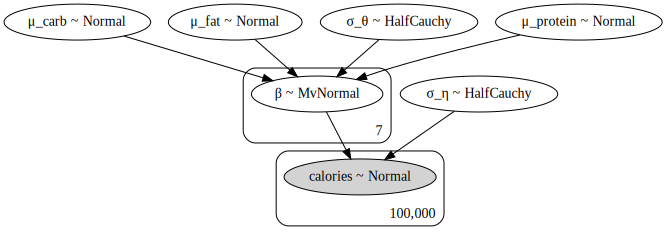

In [17]:
with pm.Model() as problem2_subj_hier_3:
    
    # Priors
    sigma_theta = pm.HalfCauchy('σ_θ', 5)
    mu_fat = pm.Normal('μ_fat', mu = 9, sd = 1e5)
    mu_protein = pm.Normal('μ_protein', mu = 4, sd = 1e5)
    mu_carb = pm.Normal('μ_carb', mu = 4, sd = 1e5)
    
    # Beta coefficients for predictor variables and intercept
    β = pm.MvNormal('β', mu=[0,mu_fat,0,0,mu_protein,0,mu_carb], cov= sigma_theta *np.eye(k+1), shape=k+1)
    # Error term
    sigma_eta = pm.HalfCauchy('σ_η', 5)
    
    # The result is a Normal, with mean based on the Betas and X-data, and variance sigma_eta.
    y_pred = pm.Normal('calories', mu = pm.math.dot(β[1:], Xtrain.T) + β[0], sd = sigma_eta, observed=Ytrain)
    
pm.model_to_graphviz(problem2_subj_hier_3)

## Run all models

In [18]:
with problem2_simple:
    # Variational inference with ADVI optimization
    advi_fit2_simple = pm.fit(50000, method='advi')
    
with problem2_subj:
    # Variational inference with ADVI optimization
    advi_fit2_subj = pm.fit(50000, method='advi')
    
with problem2_hier:
    # Variational inference with ADVI optimization
    advi_fit2_hier = pm.fit(50000, method='advi')
    
with problem2_subj_hier_7:
    # Variational inference with ADVI optimization
    advi_fit2_subj_hier_7 = pm.fit(50000, method='advi')
    
with problem2_subj_hier_3:
    # Variational inference with ADVI optimization
    advi_fit2_subj_hier_3 = pm.fit(50000, method='advi')

Average Loss = -1.5872e+05: 100%|██████████| 50000/50000 [01:46<00:00, 471.27it/s]
Finished [100%]: Average Loss = -1.5872e+05
Average Loss = -1.5872e+05: 100%|██████████| 50000/50000 [01:45<00:00, 473.36it/s]
Finished [100%]: Average Loss = -1.5872e+05
  0%|          | 0/50000 [00:00<?, ?it/s]/Users/wushenghua/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Average Loss = -1.5875e+05: 100%|██████████| 50000/50000 [02:04<00:00, 400.79it/s]
Finished [100%]: Average Loss = -1.5875e+05
  0%|          | 0/50000 [00:00<?, ?it/s]/Users/wushenghua/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional ind

In [19]:
# sample from the variational posterior distribution
PPC_SAMPLES = 5000
advi_trace2_simple = advi_fit2_simple.sample(PPC_SAMPLES)
advi_trace2_subj = advi_fit2_subj.sample(PPC_SAMPLES)
advi_trace2_hier = advi_fit2_hier.sample(PPC_SAMPLES)
advi_trace2_subj_hier_7 = advi_fit2_subj_hier_7.sample(PPC_SAMPLES)
advi_trace2_subj_hier_3 = advi_fit2_subj_hier_3.sample(PPC_SAMPLES)

## Compare the results

In [20]:
# WAIC comparisons
cmp_df = az.compare({
                     'simple':advi_trace2_simple, 
                     'subjective':advi_trace2_subj,
                     'hierarchical':advi_trace2_hier,
                     'subjective_hierarchical_7':advi_trace2_subj_hier_7,
                     'subjective_hierarchical_3':advi_trace2_subj_hier_3,
                    },
                    method='BB-pseudo-BMA')
cmp_df

/Users/wushenghua/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
subjective_hierarchical_7,0,-310312,4196.44,0,0.88384,25661.1,0,True,deviance
subjective,1,-309836,4400.61,476.196,0.112184,25376.8,492.845,True,deviance
simple,2,-309101,4889.67,1211.34,0.00397583,25156.7,1172.18,True,deviance
hierarchical,3,-308988,4926.54,1324.49,5.88426e-15,25446,858.559,True,deviance
subjective_hierarchical_3,4,-69729.3,126081,240583,0,164412,154269,True,deviance


## Distributions of $\lambda$

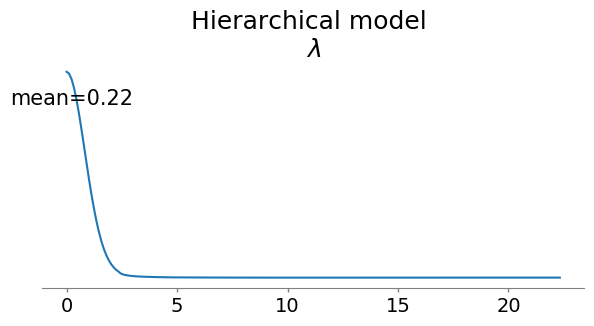

In [22]:
fig, ax = plt.subplots(dpi=100, figsize=(7,3))
pm.plot_posterior( advi_trace2_hier['σ_η']**2 / advi_trace2_hier['σ_θ']**2,
                 credible_interval=None, ax=ax)
ax.set_title("Hierarchical model \n $\lambda$", fontsize=18)
plt.show()

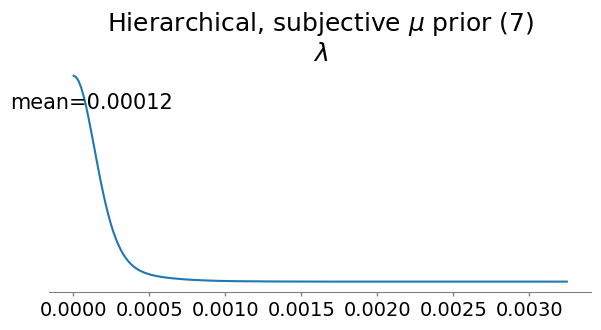

In [23]:
fig, ax = plt.subplots(dpi=100, figsize=(7,3))
pm.plot_posterior( advi_trace2_subj_hier_7['σ_η']**2 / advi_trace2_subj_hier_7['σ_θ']**2,
                 credible_interval=None, ax=ax)
ax.set_title("Hierarchical, subjective $\mu$ prior (7)\n $\lambda$", fontsize=18)
plt.show()

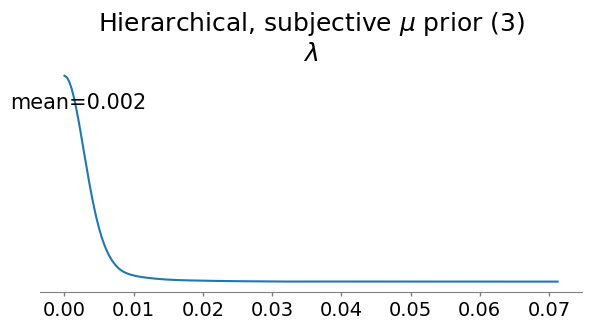

In [24]:
fig, ax = plt.subplots(dpi=100, figsize=(7,3))
pm.plot_posterior( advi_trace2_subj_hier_3['σ_η']**2 / advi_trace2_subj_hier_3['σ_θ']**2,
                 credible_interval=None, ax=ax)
ax.set_title("Hierarchical, subjective $\mu$ prior (3)\n $\lambda$", fontsize=18)
plt.show()

## Estimates and uncertainty

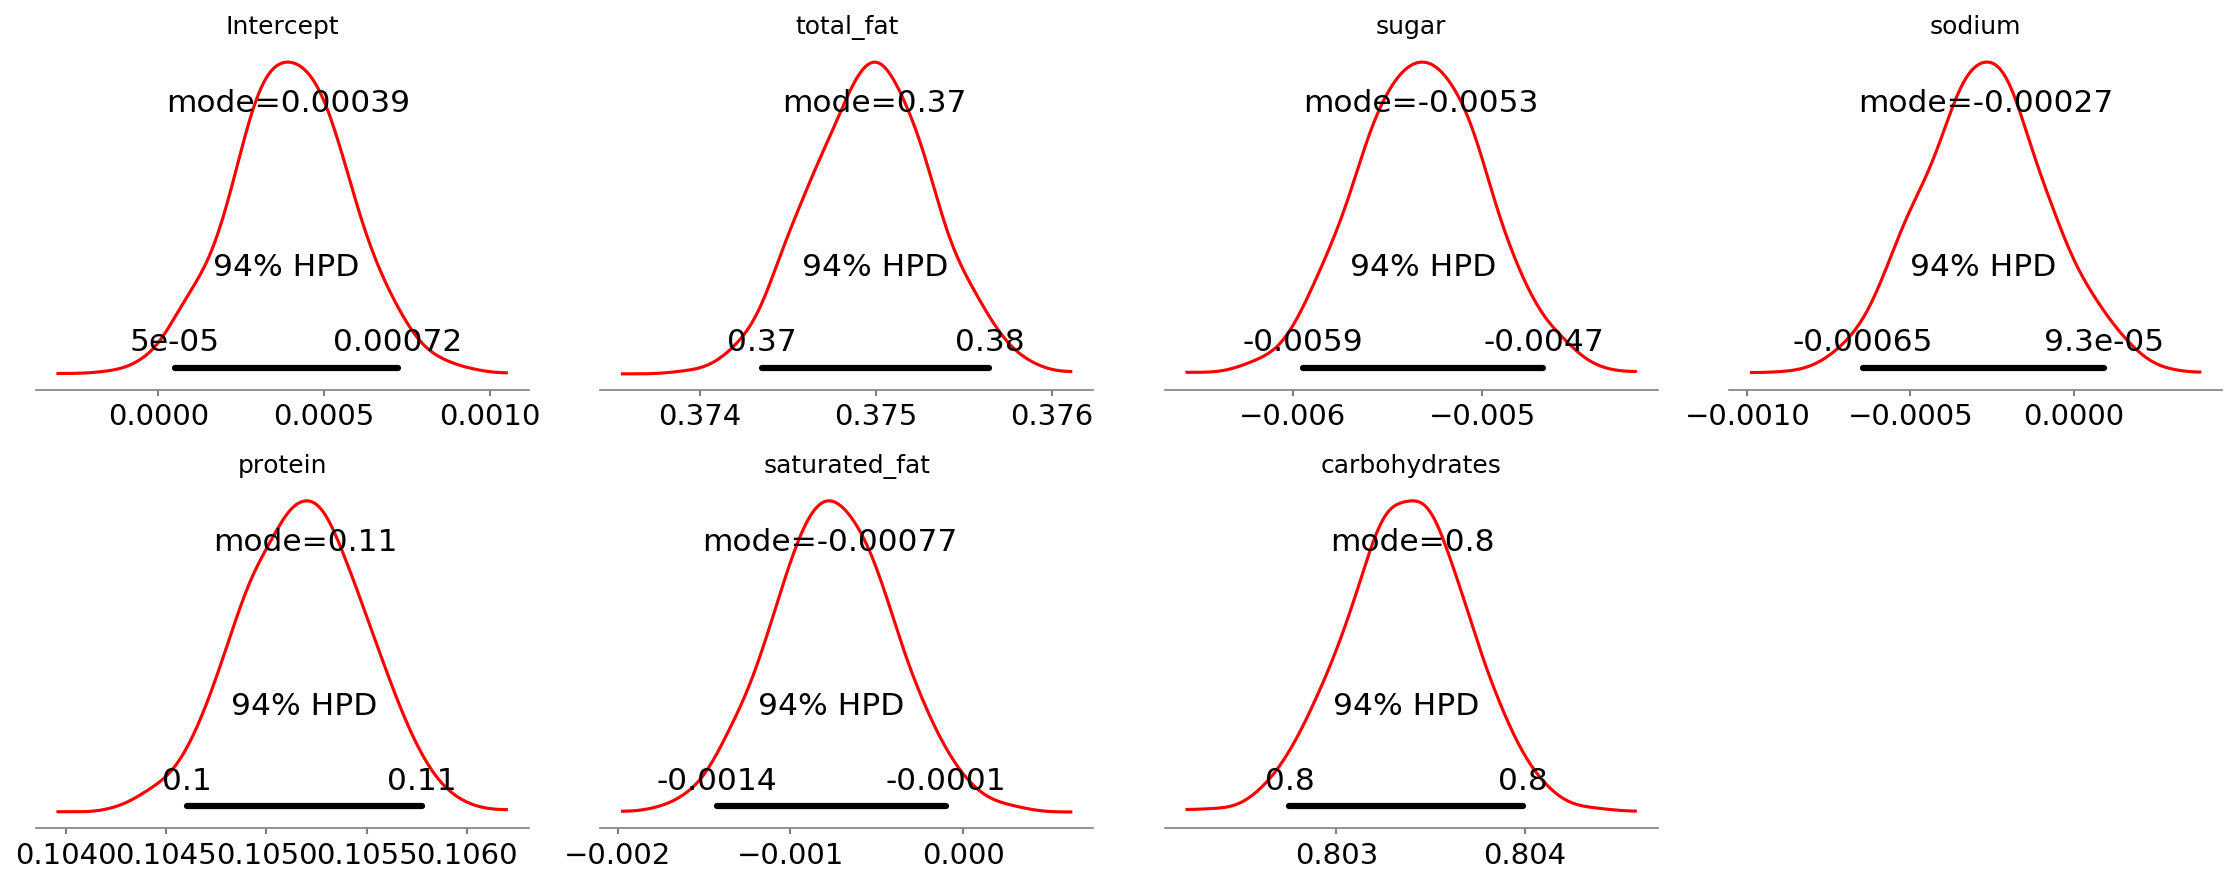

<Figure size 432x288 with 0 Axes>

In [25]:
advi_betas = advi_trace2_subj_hier_7['β']

# Plot posteriors

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6), dpi=150)
axes = axes.ravel()

for col, estimate_advi, title, xlabel in zip(range(k+1),
                               [advi_betas[:,i] for i in range(k+1)],
                               ['Intercept'] + list(data2.drop(columns=['calories']).columns),
                               ['Intercept'] + list(data2.drop(columns=['calories']).columns)):
    
    pm.plot_posterior(estimate_advi, point_estimate='mode', ax=axes[col], color='red')
    
    axes[col].set_title(title, fontsize=12)

    #axes[col].set_xlabel(xlabel, fontsize=12)
    
for ax in axes[(k+1):]:
    ax.axis('off')

plt.tight_layout()
plt.show()
plt.savefig('problem2.png')

# Problem 3

In [26]:
data3 = pd.DataFrame(recipes)

# Drop the id columns and other unnecessary columns
data3.drop(columns=['id'], inplace=True)

# As above (for tags and ingredients), reformat nutrition to be a list
# Remove [ and ] characters (at start and end)
data3['nutrition'] = data3['nutrition'].str[1:-1]
# Remove ' characters
data3['nutrition'] = data3['nutrition'].str.replace("'", "")
# Split into list
data3['nutrition'] = data3['nutrition'].str.split(", ")

# Put each nutrition fact into a properly-named column
for i, nutrition_fact in enumerate(["calories", "total_fat", "sugar", "sodium", "protein", "saturated_fat", "carbohydrates"]):
    data3[nutrition_fact] = data3['nutrition'].apply(lambda x: x[i]).astype('float64')

# Drop the now-unnecessary column
data3.drop(columns=['nutrition'], inplace=True)

# Drop unneeded columns
#data3.drop(columns=['total_fat','calories','protein','carbohydrates', 'sugar','sodium','saturated_fat'], inplace=True)

# Drop problematic values of minutes
data3 = data3[ data3['minutes'] > 0]
data3 = data3[ data3['minutes'] <= 60 * 6]

data3.head()

,minutes,n_steps,n_ingredients,calories,total_fat,sugar,sodium,protein,saturated_fat,carbohydrates
0,55,11,7,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,30,9,6,173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,130,6,13,269.8,22.0,32.0,48.0,39.0,27.0,5.0
3,45,11,11,368.1,17.0,10.0,2.0,14.0,8.0,20.0
4,190,5,8,352.9,1.0,337.0,23.0,3.0,0.0,28.0


In [27]:
# Get the X and Y variables
X = np.array(data3.drop(columns=['minutes']))
Y = np.array(data3['minutes'])
# Log-transformed Y
logY = np.log(Y)

# Scale the data
X = StandardScaler().fit_transform(X)
Y = (Y - Y.mean()) / Y.std()
logY = (logY - logY.mean()) / logY.std()

# Subset the data
Xtrain, Xtest, Ytrain, Ytest, logYtrain, logYtest = train_test_split(X, Y, logY, train_size=100000)

# Number of predictors
k = X.shape[1]

## Simple linear regression

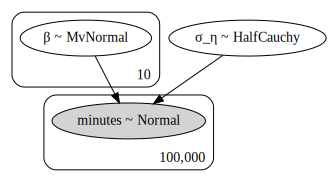

In [28]:
with pm.Model() as problem3_simple:
    
    # Beta coefficients for predictor variables and intercept
    β = pm.MvNormal('β', mu=np.zeros(k+1), cov=1e5 * np.eye(k+1), shape=k+1)
    # Error term
    sigma_eta = pm.HalfCauchy('σ_η', 5)

    # The result is a Normal, with mean based on the Betas and X-data, and variance sigma_eta.
    y_pred = pm.Normal('minutes', mu = pm.math.dot(β[1:], Xtrain.T) + β[0], sd = sigma_eta, observed=Ytrain)
    
pm.model_to_graphviz(problem3_simple)

## Simple linear regression (log-transformed $y$)

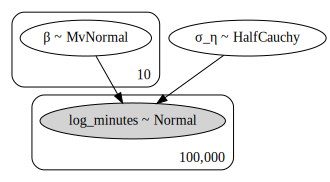

In [29]:
with pm.Model() as problem3_simple_log:
    
    # Beta coefficients for predictor variables and intercept
    β = pm.MvNormal('β', mu=np.zeros(k+1), cov=1e5 * np.eye(k+1), shape=k+1)
    # Error term
    sigma_eta = pm.HalfCauchy('σ_η', 5)

    # The result is a Normal, with mean based on the Betas and X-data, and variance sigma_eta.
    y_pred = pm.Normal('log_minutes', mu = pm.math.dot(β[1:], Xtrain.T) + β[0], sd = sigma_eta, observed=logYtrain)
    
pm.model_to_graphviz(problem3_simple_log)

## Linear regression, with hierarchical priors

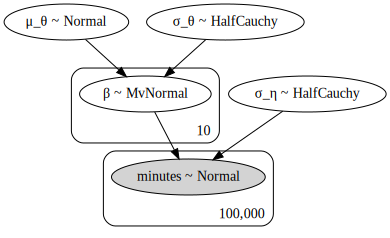

In [30]:
with pm.Model() as problem3_hier:
    
    sigma_theta = pm.HalfCauchy('σ_θ', 5)
    mu = pm.Normal('μ_θ', mu = 0, sd = 1e5)
    
    # Beta coefficients for predictor variables and intercept
    β = pm.MvNormal('β', mu=mu, cov= sigma_theta * np.eye(k+1), shape=k+1)
    sigma_eta = pm.HalfCauchy('σ_η', 5)
    
    # Calculate logit from the normal variables, and add itercept
    mu = pm.math.dot(β[1:], Xtrain.T) + β[0]

    # Pass the logits to a Bernoulli outcome, with the observed data
    y_pred = pm.Normal('minutes', mu = mu, sd = sigma_eta, observed=Ytrain)

pm.model_to_graphviz(problem3_hier)

## Linear regression, with hierarchical priors  (log-transformed $y$)

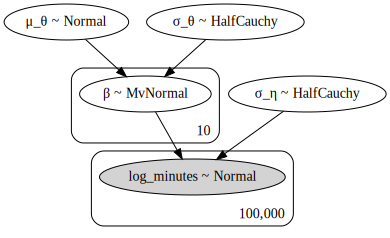

In [31]:
with pm.Model() as problem3_hier_log:
    
    sigma_theta = pm.HalfCauchy('σ_θ', 5)
    mu = pm.Normal('μ_θ', mu = 0, sd = 1e5)
    
    # Beta coefficients for predictor variables and intercept
    β = pm.MvNormal('β', mu=mu, cov= sigma_theta * np.eye(k+1), shape=k+1)
    sigma_eta = pm.HalfCauchy('σ_η', 5)
    
    # Calculate logit from the normal variables, and add itercept
    mu = pm.math.dot(β[1:], Xtrain.T) + β[0]

    # Pass the logits to a Bernoulli outcome, with the observed data
    y_pred = pm.Normal('log_minutes', mu = mu, sd = sigma_eta, observed=logYtrain)

pm.model_to_graphviz(problem3_hier_log)

## Run all models

In [32]:
# Variational inference with ADVI optimization

with problem3_simple:
    advi_fit3_simple = pm.fit(50000, method='advi')
with problem3_simple_log:
    advi_fit3_simple_log = pm.fit(50000, method='advi')
with problem3_hier:
    advi_fit3_hier = pm.fit(50000, method='advi')
with problem3_hier_log:
    advi_fit3_hier_log = pm.fit(50000, method='advi')

Average Loss = 1.3577e+05: 100%|██████████| 50000/50000 [01:54<00:00, 436.18it/s]
Finished [100%]: Average Loss = 1.3577e+05
Average Loss = 1.2857e+05: 100%|██████████| 50000/50000 [01:55<00:00, 432.88it/s]
Finished [100%]: Average Loss = 1.2857e+05
  0%|          | 0/50000 [00:00<?, ?it/s]/Users/wushenghua/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Average Loss = 1.3572e+05: 100%|██████████| 50000/50000 [02:07<00:00, 390.92it/s]
Finished [100%]: Average Loss = 1.3572e+05
Average Loss = 1.2853e+05: 100%|██████████| 50000/50000 [02:20<00:00, 356.90it/s]
Finished [100%]: Average Loss = 1.2853e+05


In [33]:
# sample from the variational posterior distribution
PPC_SAMPLES = 5000
advi_trace_simple3 = advi_fit3_simple.sample(PPC_SAMPLES)
advi_trace_simple_log3 = advi_fit3_simple_log.sample(PPC_SAMPLES)
advi_trace_hier3 = advi_fit3_hier.sample(PPC_SAMPLES)
advi_trace_hier_log3 = advi_fit3_hier_log.sample(PPC_SAMPLES)

## Compare the results

In [34]:
# WAIC comparisons
cmp_df = az.compare({
                     'simple':advi_trace_simple3,
                     'simple_log':advi_trace_simple_log3,
                     'hierarchical':advi_trace_hier3,
                     'hierarchical_log':advi_trace_hier_log3,
                    },
                    method='BB-pseudo-BMA')
cmp_df

/Users/wushenghua/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
simple_log,0,256991,68.9693,0,0.977058,551.265,0,True,deviance
hierarchical_log,1,257010,75.6963,19.3616,0.0229424,1083.94,15.4811,True,deviance
simple,2,271404,74.7706,14413.4,0,549.516,902.947,True,deviance
hierarchical,3,271405,75.1335,14414.2,0,1087.67,899.592,True,deviance


## Distributions of $\lambda$

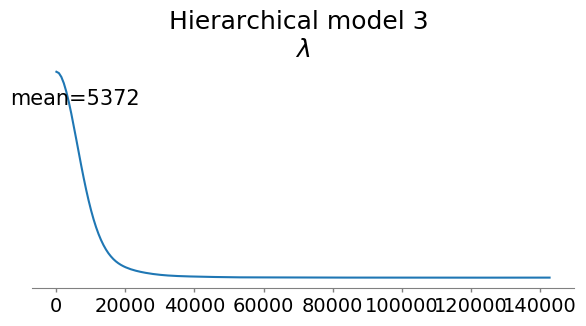

In [35]:
fig, ax = plt.subplots(dpi=100, figsize=(7,3))
pm.plot_posterior( advi_trace_hier3['σ_η']**2 / advi_trace_hier3['σ_θ']**2,
                 credible_interval=None, ax=ax)
ax.set_title("Hierarchical model 3 \n $\lambda$", fontsize=18)
plt.show()

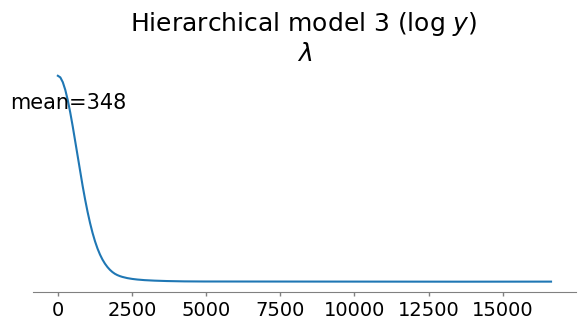

In [36]:
fig, ax = plt.subplots(dpi=100, figsize=(7,3))
pm.plot_posterior( advi_trace_hier_log3['σ_η']**2 / advi_trace_hier_log3['σ_θ']**2,
                 credible_interval=None, ax=ax)
ax.set_title("Hierarchical model 3 (log $y$) \n $\lambda$", fontsize=18)
plt.show()

## Estimates and uncertainty

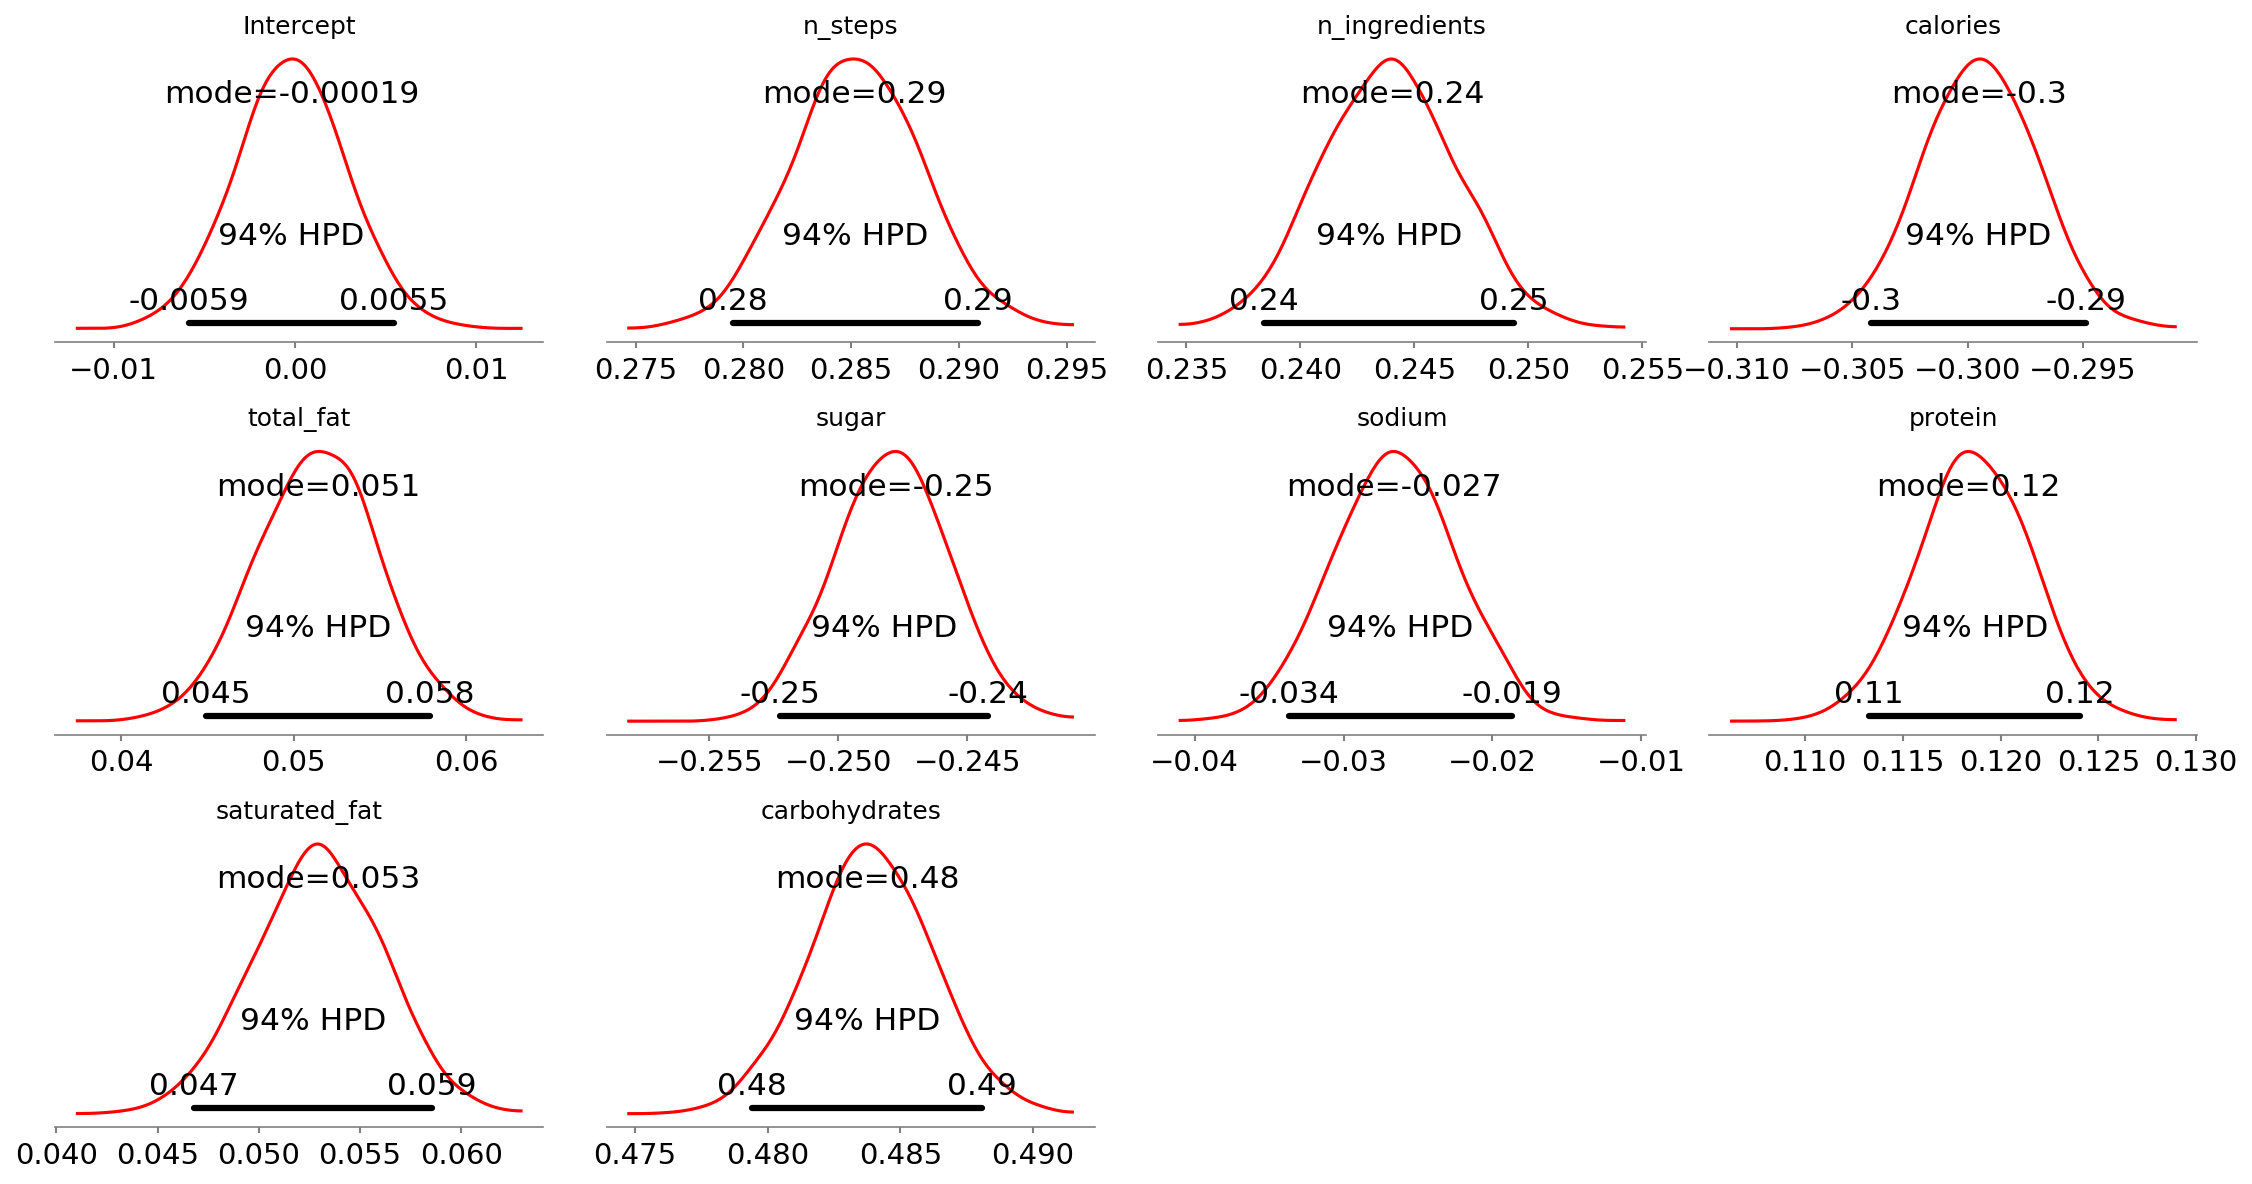

In [37]:
advi_betas = advi_trace_simple_log3['β']

# Plot posteriors

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 8), dpi=150)
axes = axes.ravel()

for col, estimate_advi, title, xlabel in zip(range(k+1),
                               [advi_betas[:,i] for i in range(k+1)],
                               ['Intercept'] + list(data3.drop(columns=['minutes']).columns),
                               ['Intercept'] + list(data3.drop(columns=['minutes']).columns)):
    
    pm.plot_posterior(estimate_advi, point_estimate='mode', ax=axes[col], color='red')
    
    axes[col].set_title(title, fontsize=12)

    #axes[col].set_xlabel(xlabel, fontsize=12)
    
for ax in axes[(k+1):]:
    ax.axis('off')

plt.tight_layout()
#plt.show()
plt.savefig('problem3.png')